# Transient simulation of a silicon npn bipolar transistor at $f=1\,\mathrm{MHz}$ and $f=1\,\mathrm{GHz}$

The graphs of the carrier concentrations and the output characteristics are stored in the folder fig.

In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt

from synumses.one_dimension.scharfetter_gummel_bernoulli import bernoulli, jacobian, update_b, first_jacobian, first_update_b, hole_current_density, electron_current_density

import synumses.one_dimension.parameters as parameters

from synumses.one_dimension.functions import  ohm_potential, calc_p_density, calc_n_density, calc_recombination

import synumses.one_dimension.solver as solver

## Definition of the transistor

Definiton of the grid points **parameters.n** and the length **parameters.lx** and the doping levels.

In [2]:
parameters.n = 600
parameters.lx = 1200E-9

parameters.init_geometry()

parameters.init_parameters()

#parameters.Cau = 0*1E-24  
# Definition of the doping levels
Nd_Emitter   = 1.2E24
Na_Base      = 4.0E22
Nd_Collector = 2.0E22

Chi = 4.05
Eg = 1.12

# np transition at x1
# pn transition at x2
x1 = 400E-9
x2 = 800E-9

for i in range(0, parameters.n):
    
    parameters.Chi[i] = Chi # Electron affinity
    parameters.Eg[i]  = Eg  # Band gap
    
    if parameters.pos_x[i] < x1:
        
        parameters.C[i] = + Nd_Emitter
    elif parameters.pos_x[i] < x2: 
        parameters.C[i] = - Na_Base
    else:
        parameters.C[i] = + Nd_Collector

## Plotting the parameters of the transistor
Now, we plot the default band diagram and the doping levels.

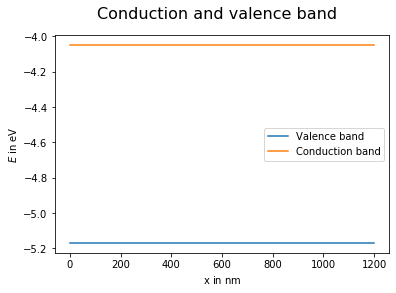

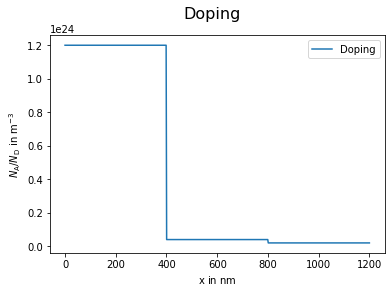

In [3]:
#
# Plot band diagram
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Conduction and valence band", fontsize=16)

axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi -  parameters.Eg, label='Valence band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi                 , label='Conduction band')


axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$E$ in $\mathrm{eV}$")

axis.legend()
plt.show()

# Doping level
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Doping", fontsize=16)

#axis.semilogy(np.abs(parameters.C), label='Doping')
axis.plot(parameters.pos_x * 1E9, np.abs(parameters.C), label='Doping')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$N_\mathrm{A} / N_\mathrm{D}$ in $\mathrm{m^{-3}}$")

axis.legend()
plt.show()


## Solve without biasing

Now, let's plot the band diagram considering diffusion but no biasing.<br>
This must be done before simulating with bias.

In [4]:
solver.solve_from_doping()

solver.solve_no_bias()

/home/pabele/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


True

## Plot band diagram

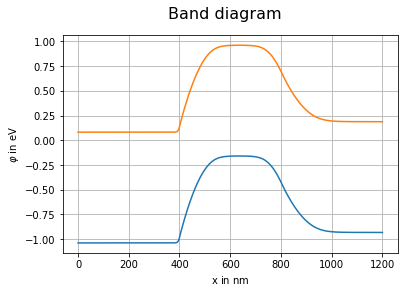

In [5]:
#
# Plot band diagram
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Band diagram", fontsize=16)

axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi -  parameters.Eg, label='Valence band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi                 , label='Conduction band')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$\varphi$ in $\mathrm{eV}$")

axis.grid()
plt.show()

## First ramping $U_\mathrm{BE}$

Now, let's ramp from $U_\mathrm{BE} = 0\,\mathrm{V}$ to $U_\mathrm{BE} = 0.6\,\mathrm{V}$.

The function *solver.solve_bias_center_boundary(.0 , .0, u_start, 650E-9, "p")* sets a further boundary condition at
the location $650\,\mathrm{nm}$ to *u_start*. As the base is p-doped the potential and the Quasi-Fermi-Level for the holes is set by
the boundary voltage. The Quasi-Fermi-Level for the electrons is not set and is calculated.


In [6]:
solver.solve_no_bias()

u_start = .00
u_stop  = .6
u_step  = 0.1


while (u_start <= u_stop):
    print("Spannung:", u_start)
    solver.solve_bias_center_boundary(.0 , .0, u_start, 650E-9, "p")
    u_start += u_step

Spannung: 0.0
Spannung: 0.1
Spannung: 0.2
Spannung: 0.30000000000000004
Spannung: 0.4
Spannung: 0.5
Spannung: 0.6


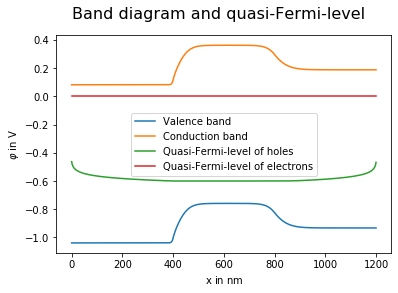

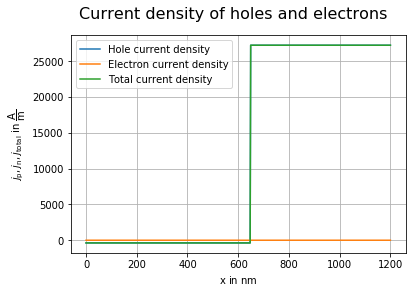

In [7]:
#
# Band diagram and quasi-Fermi-level
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Band diagram and quasi-Fermi-level", fontsize=16)

axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi -  parameters.Eg, label='Valence band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi                 , label='Conduction band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[1::3]                                  , label='Quasi-Fermi-level of holes')
axis.plot(parameters.pos_x * 1E9, -parameters.u[2::3]                                  , label='Quasi-Fermi-level of electrons')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$\varphi$ in $\mathrm{V}$")

#plt.ylim((0.95,0.96))
axis.legend()
plt.show()

    
# Hole and electron current density 
j_p =     hole_current_density()
j_n =     electron_current_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Current density of holes and electrons", fontsize=16)

axis.plot(parameters.pos_x * 1E9, j_p, label='Hole current density')
axis.plot(parameters.pos_x * 1E9, j_n, label='Electron current density')
axis.plot(parameters.pos_x * 1E9, j_n+j_p, label='Total current density')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$j_\mathrm{p}, j_\mathrm{n}, j_\mathrm{total}$ in $\mathrm{\dfrac{A}{m}}$")

axis.legend()
axis.grid()
plt.show()
 

## Ramp $U_\mathrm{CE}$

Now, let's ramp $U_\mathrm{CE}$ from §$0$ to $3\,\mathrm{V}$. This will take some time!

Save the carrier concentration in the folder *fig*.

And store the *base_current*, the *collector_current*, and the *collector_voltage* in arrays.

In [8]:
base_current = []
collector_current = []
collector_voltage = []

u_base = 0.6

u_start = 0.0
u_stop  = 2.0
u_step  = 0.05

try:
    os.makedirs("./fig")
except FileExistsError:
    # directory already exists
    pass

while (u_start <= u_stop):
    print("Spannung", u_start)
    solver.solve_bias_center_boundary(.0 , u_start, u_base, 650E-9, "p")
    
    j_p =     hole_current_density()
    j_n =     electron_current_density()
    
    base_current.append(-j_p[0])
    collector_current.append(-j_n[0])
    collector_voltage.append(u_start)
    
    u_start += u_step
    
    # Hole and electron density
    p = calc_p_density()
    n = calc_n_density()


    fig, axis = plt.subplots(1,1, sharey=True)

    fig.suptitle("Density of holes and electrons", fontsize=16)

    axis.plot(parameters.pos_x * 1E9, p, label='Hole density')
    axis.plot(parameters.pos_x * 1E9, n, label='Electron density')

    plt.ylim((0,.4E20))

    axis.set_xlabel(r"x in $\mathrm{nm}$")
    axis.set_ylabel(r"$j_n$ in $\mathrm{\dfrac{A}{m^2}}$")

    axis.grid()
    axis.legend(loc = "upper left")
    figname = './fig/carrier_concentration_{:0>4}.png'.format(str(round((u_start*1000.0))))
    plt.savefig(figname)
    plt.close()
    

Spannung 0.0
Spannung 0.05
Spannung 0.1
Spannung 0.15000000000000002
Spannung 0.2
Spannung 0.25
Spannung 0.3
Spannung 0.35
Spannung 0.39999999999999997
Spannung 0.44999999999999996
Spannung 0.49999999999999994
Spannung 0.5499999999999999
Spannung 0.6
Spannung 0.65
Spannung 0.7000000000000001
Spannung 0.7500000000000001
Spannung 0.8000000000000002
Spannung 0.8500000000000002
Spannung 0.9000000000000002
Spannung 0.9500000000000003
Spannung 1.0000000000000002
Spannung 1.0500000000000003
Spannung 1.1000000000000003
Spannung 1.1500000000000004
Spannung 1.2000000000000004
Spannung 1.2500000000000004
Spannung 1.3000000000000005
Spannung 1.3500000000000005
Spannung 1.4000000000000006
Spannung 1.4500000000000006
Spannung 1.5000000000000007
Spannung 1.5500000000000007
Spannung 1.6000000000000008
Spannung 1.6500000000000008
Spannung 1.7000000000000008
Spannung 1.7500000000000009
Spannung 1.800000000000001
Spannung 1.850000000000001
Spannung 1.900000000000001
Spannung 1.950000000000001


## Electron and hole distribution

Distribution of the electrons and holes along the semiconductor.

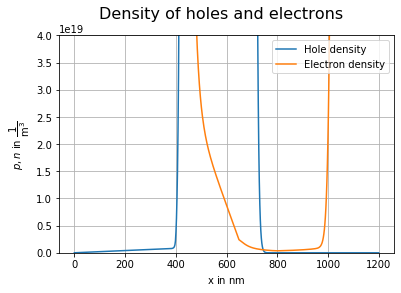

In [9]:
#
# Plot hole and electron density
#

p = calc_p_density()
n = calc_n_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Density of holes and electrons", fontsize=16)

axis.plot(parameters.pos_x * 1E9, p, label='Hole density')
axis.plot(parameters.pos_x * 1E9, n, label='Electron density')

plt.ylim((0,.4E20))

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$p, n$ in $\mathrm{\dfrac{1}{m^3}}$")

axis.grid()
axis.legend()
plt.show()




# Plot the output characteristics

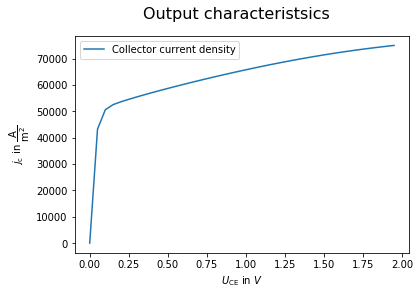

In [10]:
# Collector current density 

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Output characteristsics", fontsize=16)

axis.plot(collector_voltage,collector_current, label='Collector current density')

#plt.ylim((0,.2E20))

axis.set_xlabel(r"$U_\mathrm{CE}$ in $V$")
axis.set_ylabel(r"$j_\mathrm{c}$ in $\mathrm{\dfrac{A}{m^2}}$")

axis.legend()
plt.show()

In [11]:
sicher = parameters.u.copy()

In [12]:
#parameters.u = sicher.copy()
#
# Simulation at f=1kHz
#
u_dc_collector = 2.0
u_dc_base = 0.6
u_ac_base  = 0.1
d_t = 0.01E-3
t_steps = 200 #200 
f = 1E3


base_current_000 = []
base_current_599 = []

collector_current_000 = []
collector_current_599 = []

base_voltage = []

time = np.linspace(0, d_t * t_steps, t_steps)

for t in time:
    
    volt_base = u_dc_base + u_ac_base*np.sin(2*np.pi*f*t)
    
    print("### Voltage:", volt_base)
    print("### Steps:", t)
    solver.time_step()
    solver.solve_bias_center_boundary_transient(.0 , u_dc_collector, volt_base, 650E-9, "p", d_t)


    j_p =     hole_current_density()
    j_n = electron_current_density()
    
    
    
    base_current_000.append(-j_p[000])
    base_current_599.append(-j_p[599])
    
    collector_current_000.append(-j_n[000])
    collector_current_599.append(-j_n[599])
    
    base_voltage.append(volt_base)

### Voltage: 0.6
### Steps: 0.0
### Voltage: 0.6063105631312673
### Steps: 1.0050251256281408e-05
### Voltage: 0.6125959705067717
### Steps: 2.0100502512562815e-05
### Voltage: 0.6188311666489718
### Steps: 3.0150753768844224e-05
### Voltage: 0.6249912962370308
### Steps: 4.020100502512563e-05
### Voltage: 0.6310518031874168
### Steps: 5.0251256281407036e-05
### Voltage: 0.6369885285416547
### Steps: 6.030150753768845e-05
### Voltage: 0.6427778067710209
### Steps: 7.035175879396985e-05
### Voltage: 0.6483965601142838
### Steps: 8.040201005025126e-05
### Voltage: 0.6538223905724289
### Steps: 9.045226130653267e-05
### Voltage: 0.6590336691936528
### Steps: 0.00010050251256281407
### Voltage: 0.6640096222927107
### Steps: 0.00011055276381909548
### Voltage: 0.6687304142609184
### Steps: 0.0001206030150753769
### Voltage: 0.6731772266367076
### Steps: 0.0001306532663316583
### Voltage: 0.6773323331215338
### Steps: 0.0001407035175879397
### Voltage: 0.6811791702421021
### Steps: 0.0001507

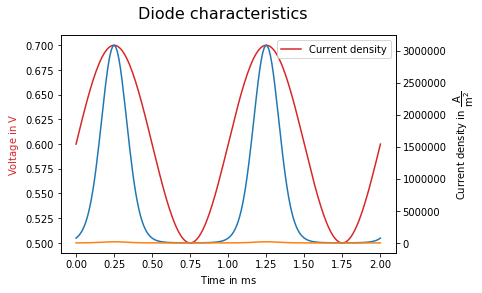

In [13]:
#
# Transistor
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Diode characteristics", fontsize=16)

axis.plot(time*1E3, base_voltage, label='Current density', color='tab:red')

axis.set_xlabel(r"Time in $\mathrm{ms}$")
axis.set_ylabel(r"Voltage in $\mathrm{V}$", color='tab:red')

axis.legend()
#plt.ylim(-1E-6,1E-6)
#plt.show()



axis2 = axis.twinx()


axis2.plot(time*1E3, collector_current_000, label='Current density')
axis2.plot(time*1E3, base_current_000, label='Current density')


axis2.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")




#plt.ylim(-1E-6,1E-6)
plt.show()


Save the output characteristsics with bias point marked for the animation.

In [14]:
parameters.u = sicher.copy()
#
# Simulation at f=1MHz
#

u_dc_collector = 2.0
u_dc_base = 0.6
u_ac_base  = 0.1
d_t = 0.01E-6
t_steps = 200 #200 
f = 1E6


base_current_000 = []
base_current_599 = []

collector_current_000 = []
collector_current_599 = []

base_voltage = []

time = np.linspace(0, d_t * t_steps, t_steps)

for t in time:
    
    volt_base = u_dc_base + u_ac_base*np.sin(2*np.pi*f*t)
    
    print("### Voltage:", volt_base)
    print("### Steps:", t)
    solver.time_step()
    solver.solve_bias_center_boundary_transient(.0 , u_dc_collector, volt_base, 650E-9, "p", d_t)


    j_p =     hole_current_density()
    j_n = electron_current_density()
    
    
    
    base_current_000.append(-j_p[000])
    base_current_599.append(-j_p[599])
    
    collector_current_000.append(-j_n[000])
    collector_current_599.append(-j_n[599])
    
    base_voltage.append(volt_base)

### Voltage: 0.6
### Steps: 0.0
### Voltage: 0.6063105631312673
### Steps: 1.0050251256281407e-08
### Voltage: 0.6125959705067717
### Steps: 2.0100502512562813e-08
### Voltage: 0.6188311666489718
### Steps: 3.0150753768844216e-08
### Voltage: 0.6249912962370308
### Steps: 4.0201005025125626e-08
### Voltage: 0.6310518031874168
### Steps: 5.0251256281407036e-08
### Voltage: 0.6369885285416547
### Steps: 6.030150753768843e-08
### Voltage: 0.6427778067710209
### Steps: 7.035175879396984e-08
### Voltage: 0.6483965601142838
### Steps: 8.040201005025125e-08
### Voltage: 0.6538223905724289
### Steps: 9.045226130653266e-08
### Voltage: 0.6590336691936528
### Steps: 1.0050251256281407e-07
### Voltage: 0.6640096222927107
### Steps: 1.1055276381909547e-07
### Voltage: 0.6687304142609184
### Steps: 1.2060301507537687e-07
### Voltage: 0.6731772266367076
### Steps: 1.3065326633165828e-07
### Voltage: 0.6773323331215338
### Steps: 1.4070351758793969e-07
### Voltage: 0.6811791702421021
### Steps: 1.507

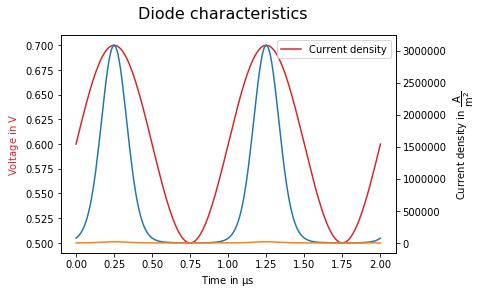

In [15]:
#
# Transistor
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Diode characteristics", fontsize=16)

axis.plot(time * 1E6, base_voltage, label='Current density', color='tab:red')

axis.set_xlabel(r"Time in $\mathrm{\mu s}$")
axis.set_ylabel(r"Voltage in $\mathrm{V}$", color='tab:red')

axis.legend()
#plt.ylim(-1E-6,1E-6)
#plt.show()



axis2 = axis.twinx()

axis2.plot(time * 1E6, collector_current_000, label='Current density')
axis2.plot(time * 1E6, base_current_000, label='Current density')



axis2.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")




#plt.ylim(-1E-6,1E-6)
plt.show()

In [18]:
parameters.u = sicher.copy()
#
# Simulation at f=1GHz
#

u_dc_collector = 2.0
u_dc_base = 0.6
u_ac_base  = 0.1
d_t = 0.0001E-6
t_steps = 200 #200 
f = 100E6


base_current_000 = []
base_current_599 = []

collector_current_000 = []
collector_current_599 = []

base_voltage = []

time = np.linspace(0, d_t * t_steps, t_steps)

for t in time:
    
    volt_base = u_dc_base + u_ac_base*np.sin(2*np.pi*f*t)
    
    print("### Voltage:", volt_base)
    print("### Steps:", t)
    solver.time_step()
    solver.solve_bias_center_boundary_transient(.0 , u_dc_collector, volt_base, 650E-9, "p", d_t)


    j_p =     hole_current_density()
    j_n = electron_current_density()
    
    
    
    base_current_000.append(-j_p[000])
    base_current_599.append(-j_p[599])
    
    collector_current_000.append(-j_n[000])
    collector_current_599.append(-j_n[599])
    
    base_voltage.append(volt_base)

### Voltage: 0.6
### Steps: 0.0
### Voltage: 0.6063105631312673
### Steps: 1.0050251256281407e-10
### Voltage: 0.6125959705067717
### Steps: 2.0100502512562814e-10
### Voltage: 0.6188311666489718
### Steps: 3.015075376884422e-10
### Voltage: 0.6249912962370308
### Steps: 4.0201005025125627e-10
### Voltage: 0.6310518031874168
### Steps: 5.025125628140703e-10
### Voltage: 0.6369885285416547
### Steps: 6.030150753768844e-10
### Voltage: 0.6427778067710209
### Steps: 7.035175879396985e-10
### Voltage: 0.6483965601142838
### Steps: 8.040201005025125e-10
### Voltage: 0.6538223905724289
### Steps: 9.045226130653266e-10
### Voltage: 0.6590336691936528
### Steps: 1.0050251256281406e-09
### Voltage: 0.6640096222927107
### Steps: 1.1055276381909548e-09
### Voltage: 0.6687304142609184
### Steps: 1.2060301507537688e-09
### Voltage: 0.6731772266367076
### Steps: 1.3065326633165828e-09
### Voltage: 0.6773323331215338
### Steps: 1.407035175879397e-09
### Voltage: 0.6811791702421021
### Steps: 1.507537

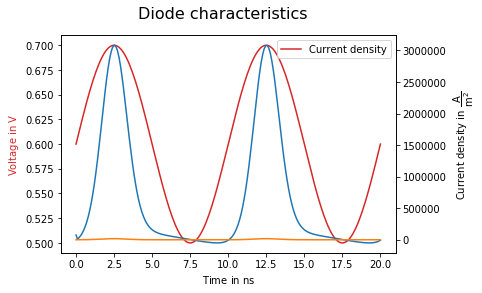

In [19]:
#
# Transistor
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Diode characteristics", fontsize=16)

axis.plot(time * 1E9, base_voltage, label='Current density', color='tab:red')

axis.set_xlabel(r"Time in $\mathrm{ns}$")
axis.set_ylabel(r"Voltage in $\mathrm{V}$", color='tab:red')

axis.legend()
#plt.ylim(-1E-6,1E-6)
#plt.show()



axis2 = axis.twinx()

axis2.plot(time * 1E9, collector_current_000, label='Current density')
axis2.plot(time * 1E9, base_current_000, label='Current density')



axis2.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")




#plt.ylim(-1E-6,1E-6)
plt.show()

In [39]:
parameters.u = sicher.copy()
#
# Simulation at f=1GHz
#


u_dc_collector = 2.0
u_dc_base = 0.6
u_ac_base  = 0.1
d_t = 0.04E-9
t_steps = 100 #200 
f = 0.5E9



base_current_000 = []
base_current_599 = []

collector_current_000 = []
collector_current_599 = []

base_voltage = []

time = np.linspace(0, d_t * t_steps, t_steps)

for t in time:
    
    volt_base = u_dc_base + u_ac_base*np.sin(2*np.pi*f*t)
    
    print("### Voltage:", volt_base)
    print("### Steps:", t)
    solver.time_step()
    solver.solve_bias_center_boundary_transient(.0 , u_dc_collector, volt_base, 650E-9, "p", d_t)


    j_p =     hole_current_density()
    j_n = electron_current_density()
    
    
    
    base_current_000.append(-j_p[000])
    base_current_599.append(-j_p[599])
    
    collector_current_000.append(-j_n[000])
    collector_current_599.append(-j_n[599])
    
    base_voltage.append(volt_base)
    

### Voltage: 0.6
### Steps: 0.0
### Voltage: 0.6126592453573749
### Steps: 4.04040404040404e-11
### Voltage: 0.6251147987181079
### Steps: 8.08080808080808e-11
### Voltage: 0.6371662455660327
### Steps: 1.212121212121212e-10
### Voltage: 0.6486196736100468
### Steps: 1.616161616161616e-10
### Voltage: 0.659290792905464
### Steps: 2.02020202020202e-10
### Voltage: 0.6690079011482112
### Steps: 2.424242424242424e-10
### Voltage: 0.6776146464291757
### Steps: 2.828282828282828e-10
### Voltage: 0.6849725429949514
### Steps: 3.232323232323232e-10
### Voltage: 0.6909631995354518
### Steps: 3.636363636363636e-10
### Voltage: 0.6954902241444074
### Steps: 4.04040404040404e-10
### Voltage: 0.6984807753012208
### Steps: 4.444444444444444e-10
### Voltage: 0.6998867339183008
### Steps: 4.848484848484848e-10
### Voltage: 0.6996854775951942
### Steps: 5.252525252525252e-10
### Voltage: 0.6978802446214778
### Steps: 5.656565656565656e-10
### Voltage: 0.6945000818714668
### Steps: 6.06060606060606e-10

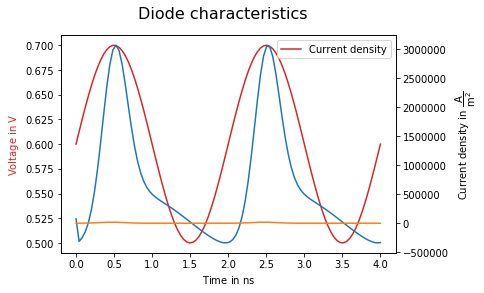

In [40]:
#
# Transistor
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Diode characteristics", fontsize=16)

axis.plot(time * 1E9, base_voltage, label='Current density', color='tab:red')

axis.set_xlabel(r"Time in $\mathrm{ns}$")
axis.set_ylabel(r"Voltage in $\mathrm{V}$", color='tab:red')

axis.legend()
#plt.ylim(-1E-6,1E-6)
#plt.show()



axis2 = axis.twinx()

axis2.plot(time * 1E9, collector_current_000, label='Current density')
axis2.plot(time * 1E9, base_current_000, label='Current density')



axis2.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")


#plt.xlim(0,10)
#plt.ylim(-1E-6,1E-6)
plt.show()